In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import numpy as np
import statsmodels.formula.api as OLS
from sklearn.linear_model import LinearRegression
import  sqlalchemy
from  sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

C:\Users\kumrajni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\kumrajni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [62]:
X1=pd.read_excel('Absence.xls',sheetname=0)
X2=pd.read_excel('Absence.xls',sheetname=1)
X3=pd.read_excel('Absence.xls',sheetname=2)
X4=pd.read_excel('Absence.xls',sheetname=3)

KeyboardInterrupt: 

In [ ]:
%timeit
data=pd.concat([X1,X2,X3,X4],ignore_index=True)

In [ ]:
data['ACTL_HRS']=data['ACTL_HRS_IN_SECND_NBR']/3600
data.drop('ACTL_HRS_IN_SECND_NBR',axis=1,inplace=True)

In [ ]:
data.rename(columns={'AGE':'Birth_Date'},inplace=True)

In [ ]:
##(pd.to_datetime('today').-pd.to_datetime('1956-07-01').year)
data['Age'] = round((datetime.datetime.now()-data['Birth_Date']).dt.days/365)
data.drop('Birth_Date',axis=1,inplace=True)

In [ ]:
data.duplicated().sum()

In [ ]:
## fill na as coalsec

%timeit data['TNUR_DT'] = data['TNUR_DT'].fillna(data['ORGNL_HIRE_DT']).fillna(data['LTST_HIRE_DT']).fillna(data['SVC_DT'])


In [ ]:
## remove where we find TNUR_DT as null
data.dropna(how='any',subset=['TNUR_DT'],inplace=True)
## if we eant to remove rows with TNUR_DT,ORGNL_HIRE_DT,LTST_HIRE_DT all three are null then
## data.dropna(how='al',subset=['TNUR_DT','ORGNL_HIRE_DT','LTST_HIRE_DT'],inplace=True)

In [ ]:
##calculating tenure
%timeit data['TENURE'] = round((datetime.datetime.now()-data['TNUR_DT']).dt.days/365)

In [ ]:
data.head()

In [ ]:
## removing categorucal value with huge unquie values and other columns
## removed job_Cd word_loc_Cd
Absence_1 = data[['MARITAL_STATUS','GENDER','FULL_TM_PART_TM_CD','REG_TEMP_CD','SAL_ADMIN_PLAN_CD','Age','TENURE','ACTL_HRS']]

In [ ]:
## checing where we have any value 'UNKNOWN'
print(Absence_1[(Absence_1['MARITAL_STATUS']).str.upper()=='UKNOWN'])
print(Absence_1[(Absence_1['GENDER']).str.upper()=='UKNOWN'])
print(Absence_1[(Absence_1['FULL_TM_PART_TM_CD']).str.upper()=='UKNOWN'])
print(Absence_1[(Absence_1['REG_TEMP_CD']).str.upper()=='UKNOWN'])
print(Absence_1[(Absence_1['SAL_ADMIN_PLAN_CD']).str.upper()=='UNKNOWN'].count()) ## has some values after replacing all are NaN

In [ ]:
## replacing unknonw with most freq from that column
Absence_1 = Absence_1.replace('UNKNOWN','GHB')

In [ ]:
Absence_1['SAL_ADMIN_PLAN_CD'].unique()
## now we have Nan instaead of UNKNOWN
##Absence_1[Absence_1['SAL_ADMIN_PLAN_CD']=='NaN']

In [ ]:
Absence_2 = pd.get_dummies(Absence_1,columns=['MARITAL_STATUS','GENDER','FULL_TM_PART_TM_CD','REG_TEMP_CD','SAL_ADMIN_PLAN_CD'],drop_first=True)

In [ ]:
Absence_2.isnull().sum()

In [ ]:
model_linear = OLS.ols(data=Absence_2,formula="ACTL_HRS~TENURE+Age+GENDER_M+MARITAL_STATUS_S+FULL_TM_PART_TM_CD_P+REG_TEMP_CD_T+SAL_ADMIN_PLAN_CD_GHB+SAL_ADMIN_PLAN_CD_S1").fit()
##logit = OLS.logit(data=Absence_2,formula="ACTL_HRS~'TENURE','Age','GENDER_M','MARITAL_STATUS_S','FULL_TM_PART_TM_CD_P','REG_TEMP_CD_T','SAL_ADMIN_PLAN_CD_GHB','SAL_ADMIN_PLAN_CD_S1")"
model_linear.summary()

In [ ]:
## as per above analysis Age is not that significant as its p-value is more then 0.05
## lets remove that Age and rebuild our mode## 
model_linear = OLS.ols(data=Absence_2,formula="ACTL_HRS~TENURE+GENDER_M+MARITAL_STATUS_S+FULL_TM_PART_TM_CD_P+REG_TEMP_CD_T+SAL_ADMIN_PLAN_CD_GHB+SAL_ADMIN_PLAN_CD_S1").fit()
model_linear.summary()


## with SKLEARN ##

In [ ]:
Feature_Columns = ['TENURE','MARITAL_STATUS_S','GENDER_M','FULL_TM_PART_TM_CD_P','REG_TEMP_CD_T','SAL_ADMIN_PLAN_CD_GHB','SAL_ADMIN_PLAN_CD_S1']
X = Absence_2[Feature_Columns]
y = Absence_2['ACTL_HRS']

In [ ]:
Absence_2.head()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)


In [ ]:
## root mean square error
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_predict))
print(RMSE)

In [ ]:
X_train.head()
pre = model.predict([['2','1','0','0','0','1','0']])
[20,1,0,0,0,1,0]
1,0,0,0,1,0

In [ ]:
corr = X_train.corr(method='pearson')
print('--------------Create a Corelation plot------------------')


### Summing the duplicated Absence ####

In [ ]:
##data[data['ACTL_HRS']<0].count()
data['ACTL_HRS'][data['ACTL_HRS']<0] = data['ACTL_HRS'][data['ACTL_HRS']<0]*-1

In [ ]:
Absence_2.duplicated().sum()

In [ ]:
Absence_2.corr(method='pearson')

In [ ]:
Absence_2.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
## if it is 1 then it is cprelated

In [ ]:
##type(data[data['PERS_OBJ_ID']=='M5KIT3YBGHPHESNB']['PERS_OBJ_ID']) Series
##type(data[data['PERS_OBJ_ID']=='M5KIT3YBGHPHESNB'][['PERS_OBJ_ID','YR_CD']])  M5KIT3YBGHPHESNB 2017
data[(data['PERS_OBJ_ID']=='M5KIT3YBGHPHESNB') & (data['YR_CD']==2017)]

In [ ]:
temp_d = Absence_2
Absence_2.columns


In [ ]:
type(temp_d.groupby(['Age', 'TENURE', 'MARITAL_STATUS_S', 'GENDER_M',
       'FULL_TM_PART_TM_CD_P', 'REG_TEMP_CD_T', 'SAL_ADMIN_PLAN_CD_GHB',
       'SAL_ADMIN_PLAN_CD_S1'])['ACTL_HRS'].sum())

In [ ]:
data['MARITAL_STATUS'].unique()

In [ ]:
pre = model.predict([[57,1,2.5,0,0,1,0],[57,1,2.5,0,0,1,0],[57,1,2.5,0,0,1,0],[57,1,2.5,0,0,1,0],[57,1,2.5,0,0,1,0]])
pre

In [ ]:
pre = model.predict([[2,1,0,0,0,1,0]])--#
pre.sum()

In [ ]:
## M5O303VCFXZU9K4Q G34XBQHFME8GDKSD
##


### Absence HUE ##################################

In [ ]:
data = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence_G3WK8PFWBKJGZRWN.csv",header=0)

In [ ]:
data.rename(columns={'p.hr_job_dsc':'job_dsc','p.hr_birth_yr':'birth_yr','p.marital_status_':'marital_status','p.hr_gndr_dsc':'gender','p.hr_full_tm_part_tm_dsc':'full_tm_prt_tm_dsc','p.hr_reg_temp_cd':'reg_temp_cd','p.tenure_':'tenure'},inplace=True)

In [ ]:
data.shape

In [ ]:
data.replace(0,np.nan,inplace=True)

In [ ]:
data.isnull().sum()

In [ ]:
data.dropna(inplace=True)
##data.shape

In [ ]:
plt.figure(figsize=(19,10))
plt.plot(data.sample(frac=0.3,random_state=2)['nbr_emp'],data.sample(frac=0.3,random_state=2)['absence_hrs'])
plt.show()

In [ ]:
data.sample(frac=0.3,random_state=2)['absence_hrs'].max()

In [ ]:
##data['job_dsc'=='Team Member']
data.head()

In [ ]:
##sns.pairplot(data.sample(frac=0.3,random_state=2)[['absence_hrs','nbr_emp','tenure']])
##data.rename(columns={'p.tenure_':'tenure'},inplace=True)
t = (data.sample(frac=0.3,random_state=2)[['absence_hrs','nbr_emp','tenure']]).dropna()
sns.pairplot(t)
plt.show()

In [ ]:
t.head()
plt.scatter(t['tenure'],t['absence_hrs'])
plt.show()

In [ ]:
data.drop('job_dsc',axis=1,inplace=True)

In [ ]:
data.duplicated().sum()
data.drop(data.index[data.duplicated()],inplace=True)

In [ ]:
data.duplicated().sum()
data.shape

In [ ]:
print(data['absence_hrs'].mean())
print(data['absence_hrs'].min())
print(data['absence_hrs'].max())

In [ ]:
data[data['absence_hrs']<0].count()

In [ ]:
## any outliers
plt.figure(figsize=(20,10))
plt.hist(data['absence_hrs'],bins=20)
plt.show()

In [ ]:
## both are same
%matplotlib inline
plt.figure(figsize=(15,5))
data['absence_hrs'].hist(bins=20)

In [ ]:
## removing all the neaftive absence 
## negative <0 
data.drop(data.index[data['absence_hrs']<0],inplace=True)

In [ ]:
data.index[data['absence_hrs']<0]

In [ ]:
data.isnull().sum()

In [ ]:
print(data['absence_hrs'].mean())
print(data['absence_hrs'].min())
print(data['absence_hrs'].max())

In [ ]:
## both are same
%matplotlib inline
plt.figure(figsize=(15,5))
data['absence_hrs'].hist(bins=20)

In [ ]:
data.boxplot(return_type='dict')
plt.plot()

In [ ]:
##Finding outliers
q1 = np.percentile((data['absence_hrs']),25)
q3 =  np.percentile((data['absence_hrs']),75)
IQR = q3-q1
floor = q1-1.5*IQR
ceiling = q3 + 1.5*IQR
print(q1,q3,IQR,floor,ceiling)

In [ ]:
data[(data['absence_hrs']<q1) | (data['absence_hrs']>q3)]

In [ ]:
## removing outliers
data.drop(data.index[(data['absence_hrs']<q1) | (data['absence_hrs']>q3)],inplace=True)

In [ ]:
data.shape

In [ ]:
data.head()

In [ ]:
## finding unique of each columns
for i in range(len(data.columns)):
    if(i==0 | i == 1):
        continue
    else:        
        print(data[data.columns[i]].unique())

In [ ]:
data[data['gender']=='Not Specified'].shape

In [ ]:
## remove all with Not specified
data.drop(data.index[(data['gender']=='Not Specified')],inplace=True)
print(data.shape)

In [ ]:
## calculatin age in Age columsn
data['Age'] = datetime.datetime.now().year - data['birth_yr']
data.head()

In [ ]:
## drop birthyear
data.drop('birth_yr',inplace=True,axis=1)
data.head()

In [ ]:
data = pd.get_dummies(data,columns=['marital_status','gender','full_tm_prt_tm_dsc','reg_temp_cd'],drop_first=True)

In [ ]:
## finding corelation
data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
## if it is 1 then it is cprelated

In [ ]:
data.rename(columns={'full_tm_prt_tm_dsc_Part-Time':'full_tm_prt_tm_dsc_Part_Time'},inplace=True)

In [ ]:
## analyzing with statsmodel
model_stat = OLS.ols(data=data,formula="absence_hrs~nbr_emp+tenure+Age+marital_status_S+gender_Male+full_tm_prt_tm_dsc_Part_Time+reg_temp_cd_T").fit()

In [ ]:
model_stat.summary()
## with this data we find age as a significant feature

### with SKLEARN ###

In [ ]:
## splitting
y = data['absence_hrs']
X = data[['nbr_emp','tenure','Age','marital_status_S','full_tm_prt_tm_dsc_Part_Time','reg_temp_cd_T']]
X_Train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=2)

In [ ]:
print(X_Train.shape,X_test.shape,y_train.shape,y_test.shape)

In [ ]:
mode_lin = LinearRegression()
mode_lin.fit(X_Train,y_train)
y_pred = mode_lin.predict(X_test)

In [ ]:
print(y.mean())
print(y.max())
print(y.min())

In [ ]:
## RMSE
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

## ********************************Absence Percentage **********************************####

In [ ]:
lis = os.listdir("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence")

In [ ]:
lis

In [ ]:
df0 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[1],header=0)
df1 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[2],header=0)
df2 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[3],header=0)
df3 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[4],header=0)
df4 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[5],header=0)
df5 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[6],header=0)
df6= pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[7],header=0)
df7 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[8],header=0)
df8 = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\"+lis[0],header=0)

In [ ]:
df = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7,df8],ignore_index=True)

In [ ]:
print(df.shape)
df.head()

In [ ]:
## calculating Absence_perc
df['Absence'] = df['absence_hrs']/df['total_hrs']
df['age'] = datetime.datetime.now().year-df['p.hr_birth_yr']
df.drop(['total_hrs','absence_hrs','p.hr_job_dsc','p.hr_birth_yr'],inplace=True,axis=1)
df = df.rename(columns={'p.marital_status_':'marital_status','p.hr_gndr_dsc':'gender','p.hr_full_tm_part_tm_dsc':'full_tm_part_tm','p.hr_reg_temp_cd':'reg_temp','p.tenure_':'tenure'})
df.head()

In [ ]:
## check unique values in all columns and replace ohter than valid to np.nan
for i in range(len(df.columns)):
    if(i==0 or i == 1):
        continue
    else:        
        print(df.columns[i]+str(df[df.columns[i]].unique()))

In [ ]:
## dropping where gender is not specified
df.drop(df.index[df['gender']=='Not Specified'],inplace=True)

In [ ]:
##dropping all where absence =1 
df.drop(df.index[df['Absence']==0],inplace=True)
df.shape

In [ ]:
df.drop(df.index[df['Absence']<0],inplace=True)

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
plt.figure(figsize=(14,9))
plt.plot(df.sample(frac=0.3,random_state=2)['avg_salary'],df.sample(frac=0.3,random_state=2)['Absence'])
plt.show()

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.hist(df['Absence'],bins=10,range=(0,5))
plt.show()

In [ ]:
print(df['Absence'].min())
print(df['Absence'].mean())
print(df['Absence'].max())

In [ ]:
##sns.pairplot(data.sample(frac=0.3,random_state=2)[['absence_hrs','nbr_emp','tenure']])
## analysing with three numerical value
t = (df.sample(frac=0.3)[['Absence','nbr_emp','tenure']])
sns.pairplot(t)
plt.show()

In [ ]:
##Finding outliers
q1 = np.percentile((df['Absence']),25)
q3 =  np.percentile((df['Absence']),75)
IQR = q3-q1
floor = q1-1.5*IQR
ceiling = q3 + 1.5*IQR
print(q1,q3,IQR,floor,ceiling)

In [ ]:
## listintg oulioers
df[(df['Absence']<floor) | (df['Absence']>ceiling)].shape

In [ ]:
## removing poutliers
df.drop(df.index[(df['Absence']<floor) | (df['Absence']>ceiling)],inplace=True)
df.shape

In [ ]:
print(df.shape)
df.head()

In [ ]:
df = pd.get_dummies(data=df,columns=['marital_status','gender','full_tm_part_tm','reg_temp'],drop_first=True)

In [ ]:
df.rename(columns={'full_tm_part_tm_Part-Time':'full_tm_part_tm_Part_Time'},inplace=True)

In [ ]:
df.head()

In [ ]:
df.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

### model analysis using stat model

In [ ]:
ols_model = OLS.ols(data=df, formula="Absence~avg_salary+nbr_emp+tenure+age+marital_status_S+gender_Male+full_tm_part_tm_Part_Time+reg_temp_T").fit()

In [ ]:
ols_model.summary()

In [ ]:
## every feature seems to be significant preiously age was coming more than 0.05

## with SKlearn ###

In [ ]:
df.head()

In [ ]:
feature_columns = ['avg_salary','nbr_emp','tenure','age','marital_status_S','gender_Male','full_tm_part_tm_Part_Time','reg_temp_T']
X = df[feature_columns]
y = df['Absence']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=2)

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)

In [ ]:
print(model.intercept_) ## intercenpt in OLS and sklearn seems to be same
print(set(zip(feature_columns, model.coef_)))


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print(RMSE)

In [ ]:
r2Score = metrics.r2_score(y_test,y_pred)
r2Score

In [ ]:
print(df['Absence'].max())
print(df['Absence'].mean())
print(df['Absence'].min())

In [ ]:
## we see tjat male absnece percentage is more than 

## ******************************************************END **********************************************

### Testing with one random client data ###

In [ ]:
test = pd.read_csv("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Absence\\Test\\Absence_G3V0M1670KYADKSJ.csv",header=0)

In [ ]:
def refinedf(dataframe):
    dataframe['Absence'] = dataframe['absence_hrs']/dataframe['total_hrs']
    dataframe['age'] = datetime.datetime.now().year-dataframe['p.hr_birth_yr']
    dataframe.drop(['total_hrs','absence_hrs','p.hr_job_dsc','p.hr_birth_yr'],inplace=True,axis=1)
    dataframe =dataframe.rename(columns={'p.marital_status_':'marital_status','p.hr_gndr_dsc':'gender','p.hr_full_tm_part_tm_dsc':'full_tm_part_tm','p.hr_reg_temp_cd':'reg_temp','p.tenure_':'tenure'})
    dataframe.drop(dataframe.index[dataframe['gender']=='Not Specified'],inplace=True)
    dataframe.drop(dataframe.index[dataframe['Absence']==0],inplace=True)
    dataframe.drop(dataframe.index[dataframe['Absence']<0],inplace=True)
    dataframe.dropna(inplace=True)
    print(dataframe.head())
    return dataframe

In [ ]:
def removeOutliers(dataframe):
    q1 = np.percentile((dataframe['Absence']),25)
    q3 =  np.percentile((dataframe['Absence']),75)
    IQR = q3-q1
    floor = q1-1.5*IQR
    ceiling = q3 + 1.5*IQR
    dataframe.drop(dataframe.index[(dataframe['Absence']<floor) | (dataframe['Absence']>ceiling)],inplace=True)
    return dataframe

In [ ]:
def getDummies(dataframe):
    dataframe = pd.get_dummies(data=dataframe,columns=['marital_status','gender','full_tm_part_tm','reg_temp'],drop_first=True)
    dataframe.rename(columns={'full_tm_part_tm_Part-Time':'full_tm_part_tm_Part_Time'},inplace=True)
    return dataframe

In [ ]:
def predicted_Absece(dataframe):
    client_pram = dataframe[['avg_salary','nbr_emp','tenure','age','marital_status_S','gender_Male','full_tm_part_tm_Part_Time','reg_temp_T']]
    client_pred  = model.predict(client_pram)
    return client_pred

In [ ]:
def calRMSEClient(dataframe):
    return np.sqrt(metrics.mean_squared_error(dataframe['Absence'],predicted_Absece(dataframe)))

In [ ]:
test = refinedf(test)
test = removeOutliers(test)
test =  getDummies(test)

In [ ]:
print(calRMSEClient(test))

In [ ]:
test  = test.rename(columns={'p.marital_status_':'marital_status'})

In [ ]:
test.head()

#### removing all the outliers

In [ ]:
df.head()

In [ ]:
##Finding outliers
q1_sal = np.percentile((df['avg_salary']),25)
q3_sal =  np.percentile((df['avg_salary']),75)
IQR_sal = q3_sal-q1_sal
floor_sal = q1_sal-1.5*IQR_sal
ceiling_sal = q3_sal + 1.5*IQR_sal
print(q1_sal,q3_sal,IQR_sal,floor_sal,ceiling_sal)

In [ ]:
##drop all outliers with respect to avg salary
## removing poutliers
df.drop(df.index[(df['avg_salary']<floor_sal) | (df['avg_salary']>ceiling_sal)],inplace=True)
df.shape

In [ ]:
##Finding outliers with respect to number of people
q1_sal = np.percentile((df['nbr_emp']),25)
q3_sal =  np.percentile((df['nbr_emp']),75)
IQR_sal = q3_sal-q1_sal
floor_sal = q1_sal-1.5*IQR_sal
ceiling_sal = q3_sal + 1.5*IQR_sal
print(q1_sal,q3_sal,IQR_sal,floor_sal,ceiling_sal)
df.drop(df.index[(df['nbr_emp']<floor_sal) | (df['nbr_emp']>ceiling_sal)],inplace=True)
df.shape

In [ ]:
ols_model_2 = OLS.ols(data=df, formula="Absence~avg_salary+nbr_emp+tenure+age+marital_status_S+gender_Male+full_tm_part_tm_Part_Time+reg_temp_T").fit()
ols_model_2.summary()

In [ ]:
df.head()

### ********************************************** Absence tenure band******************************** ####

In [63]:
Excels = os.listdir("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence")


In [64]:
Excels[0]

'Absence_G385HQ0GG37BHG07_G3X6R9V946MX8JBD.csv'

In [65]:
df1 = pd.read_csv("C:\\Users\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\"+Excels[0],header=0)
df2 = pd.read_csv("C:\\Users\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\"+Excels[1],header=0)
df3 = pd.read_csv("C:\\Users\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\"+Excels[2],header=0)

In [66]:
data = pd.concat([df1,df2,df3],ignore_index=True)

In [67]:
data.head()

,total_hrs,absence_hrs,avg_salary,nbr_emp,p.hr_job_dsc,p.hr_birth_yr,p.marital_status_,p.hr_gndr_dsc,p.hr_full_tm_part_tm_dsc,p.hr_reg_temp_cd,p.tenure_band_
0,14672.000000,4628.00,5342.771974,3090,"""Technician """"A""""""",1957,M,Male,Full-Time,R,Over 15 Years
1,2809.966667,0.00,2901.330000,740,01BESP,1974,S,Female,Full-Time,R,Under 1 Year
2,22510.250000,2046.00,2375.010000,6806,2S-Administrative Assistant,1994,S,Female,Full-Time,R,3-5 Years
3,11796.000000,-1610.00,513.276055,4644,2S-Intern,1998,S,Male,Full-Time,T,Under 1 Year
4,3510.500000,29.75,1088.800000,826,2S-Receptionist,1986,S,Female,Full-Time,R,2-3 Years


In [68]:
## calculating Absence_perc
data['Absence'] = data['absence_hrs']/data['total_hrs']
data['age'] = datetime.datetime.now().year-data['p.hr_birth_yr']
data.drop(['total_hrs','absence_hrs','p.hr_job_dsc','p.hr_birth_yr'],inplace=True,axis=1)
data = data.rename(columns={'p.marital_status_':'marital_status','p.hr_gndr_dsc':'gender','p.hr_full_tm_part_tm_dsc':'full_tm_part_tm','p.hr_reg_temp_cd':'reg_temp','p.tenure_band_':'tenure_band'})

In [69]:
data.head()

,avg_salary,nbr_emp,marital_status,gender,full_tm_part_tm,reg_temp,tenure_band,Absence,age
0,5342.771974,3090,M,Male,Full-Time,R,Over 15 Years,0.315431,61
1,2901.330000,740,S,Female,Full-Time,R,Under 1 Year,0.000000,44
2,2375.010000,6806,S,Female,Full-Time,R,3-5 Years,0.090892,24
3,513.276055,4644,S,Male,Full-Time,T,Under 1 Year,-0.136487,20
4,1088.800000,826,S,Female,Full-Time,R,2-3 Years,0.008475,32


In [70]:
## check unique values in all columns and replace ohter than valid to np.nan
for i in range(len(data.columns)):
    if(i==0 or i == 1):
        continue
    else:        
        print(data.columns[i]+str(data[data.columns[i]].unique()))

marital_status['M' 'S']
gender['Male' 'Female' 'Not Specified']
full_tm_part_tm['Full-Time' 'Part-Time']
reg_temp['R' 'T']
tenure_band['Over 15 Years' 'Under 1 Year' '3-5 Years' '2-3 Years' '1-2 Years'
 '10-15 Years' '5-10 Years' 'Unknown']
Absence[ 0.31543075  0.          0.09089193 ...,  0.36338147  0.21469997
  0.21740774]
age[ 61  44  24  20  32  34  66  49  38  30  29  27  26  21  19  18  17  41
  55  57  63  62  60  58  56  54  53  51  50  47  46  45  42  40  39  37
  35  33  31  28  25  67  43  36  70  64  59  52  48  68  77  72  71  65
  23  22  69  82  75  74  73  80  76  78  81  16  85  79   1  83  88  87
  90  84  93   5  89  98  96   3  15  86  92 114 110 106  91 109 112]


In [ ]:
data[data['tenure_band']=='Unknown'].shape

In [ ]:
## dropping where gender is not specified
data.drop(data.index[data['gender']=='Not Specified'],inplace=True)
data.drop(data.index[data['tenure_band']=='Unknown'],inplace=True)
##dropping all where absence =1 
data.drop(data.index[data['Absence']==0],inplace=True)
data.drop(data.index[data['Absence']<0],inplace=True)
data.dropna(inplace=True)

In [ ]:
data = data.round(2)

In [ ]:
data = pd.get_dummies(data=data,columns=['marital_status','gender','full_tm_part_tm','reg_temp','tenure_band'],drop_first=True)



In [ ]:
data.rename(columns={'full_tm_part_tm_Part-Time':'full_tm_part_tm_Part_Time'},inplace=True)


In [ ]:
data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [ ]:
data.rename(columns={'tenure_band_10-15 Years':'tenure_band_10_15','tenure_band_2-3 Years':'tenure_band_2_3','tenure_band_3-5 Years':'tenure_band_3_5','tenure_band_5-10 Years':'tenure_band_5_10 ','tenure_band_Over 15 Years':'tenure_band_Over_15','tenure_band_Under 1 Year':'tenure_band_Under_1 '},inplace=True)

In [ ]:
data.rename(columns={'tenure_band_5_10 ':'tenure_band_5_10'},inplace=True)

In [ ]:
data.columns

In [ ]:
ols_model = OLS.ols(data=data, formula="Absence~avg_salary+nbr_emp+age+full_tm_part_tm_Part_Time+reg_temp_T+tenure_band_10_15+tenure_band_2_3+tenure_band_3_5+tenure_band_5_10+tenure_band_Over_15+tenure_band_Under_1").fit()

In [ ]:
ols_model.summary()

In [ ]:
##Finding outliers
q1 = np.percentile((data['Absence']),25)
q3 =  np.percentile((data['Absence']),75)
IQR = q3-q1
floor = q1-1.5*IQR
ceiling = q3 + 1.5*IQR
print(q1,q3,IQR,floor,ceiling)



In [ ]:
## listintg oulioers
data[(data['Absence']<floor) | (data['Absence']>ceiling)].shape



In [ ]:
## removing poutliers
data.drop(data.index[(data['Absence']<floor) | (data['Absence']>ceiling)],inplace=True)
data.shape

In [ ]:
data.drop(labels='gender_Male',axis=1,inplace=True)

In [ ]:
data.head()

In [ ]:
##Finding outliers
q1_sal = np.percentile((data['avg_salary']),25)
q3_sal =  np.percentile((data['avg_salary']),75)
IQR_sal = q3_sal-q1_sal
floor_sal = q1_sal-1.5*IQR_sal
ceiling_sal = q3_sal + 1.5*IQR_sal
print(q1_sal,q3_sal,IQR_sal,floor_sal,ceiling_sal)



In [ ]:
## listintg oulioers
data[(data['avg_salary']<floor_sal) | (data['avg_salary']>ceiling_sal)].shape



In [ ]:
data.drop(data.index[(data['avg_salary']<floor_sal) | (data['avg_salary']>ceiling_sal)],inplace=True)
data.shape

In [ ]:
##Finding outliers
q1_nbr = np.percentile((data['nbr_emp']),25)
q3_nbr =  np.percentile((data['nbr_emp']),75)
IQR_nbr = q3_nbr-q1_nbr
floor_nbr = q1_nbr-1.5*IQR_nbr
ceiling_nbr = q3_nbr + 1.5*IQR_nbr
print(q1_nbr,q3_nbr,IQR_nbr,floor_nbr,ceiling_nbr)


In [ ]:
## listintg oulioers
data[(data['nbr_emp']<floor_nbr) | (data['nbr_emp']>ceiling_nbr)].shape


In [ ]:
data.drop(data.index[(data['nbr_emp']<floor_nbr) | (data['nbr_emp']>ceiling_nbr)],inplace=True)
data.shape

In [ ]:
data.duplicated().sum()
data.drop_duplicates(inplace=True)

In [ ]:
## removing marital stus
data.drop('marital_status_S',inplace=True,axis=1)

In [ ]:
##Finding outliers
q1_age = np.percentile((data['age']),25)
q3_age =  np.percentile((data['age']),75)
IQR_age = q3_age-q1_age
floor_age = q1_age-1.5*IQR_age
ceiling_age = q3_age + 1.5*IQR_age
print(q1_age,q3_age,IQR_age,floor_age,ceiling_age)

In [ ]:
## listintg oulioers
data[(data['age']<floor_age) | (data['age']>ceiling_age)].shape

In [ ]:
data.drop(data.index[(data['age']<floor_age) | (data['age']>ceiling_age)],inplace=True)
data.shape

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.hist(data['Absence'],bins=10,range=(0,5))
plt.show()

## ********************Absence with bands ##************************************************************

In [108]:
lists = os.listdir("C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Band")

In [109]:
lists
path = "C:\\Users\\kumrajni\\AppData\\Local\\Continuum\\anaconda3\\Scripts\\Jupyter_Learnign\\Jupyter_Learnign\\Absence\\Band\\"

In [110]:
fd1 = pd.read_csv(path+lists[0],header=0)
fd2 = pd.read_csv(path+lists[1],header=0)
fd3 = pd.read_csv(path+lists[2],header=0)

In [111]:
data = pd.concat([fd1,fd2,fd3],ignore_index=True)

In [112]:
data.info()
##121928-3  ecause three are headerts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121925 entries, 0 to 121924
Data columns (total 11 columns):
total_hrs                   121925 non-null float64
absence_hrs                 121925 non-null float64
avg_salary                  121925 non-null float64
nbr_emp                     121925 non-null int64
p.hr_job_dsc                121925 non-null object
p.age_band_                 121925 non-null object
p.marital_status_           121925 non-null object
p.hr_gndr_dsc               121925 non-null object
p.hr_full_tm_part_tm_dsc    121925 non-null object
p.hr_reg_temp_cd            121925 non-null object
p.tenure_band_              121925 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 10.2+ MB


In [113]:
data.head()

,total_hrs,absence_hrs,avg_salary,nbr_emp,p.hr_job_dsc,p.age_band_,p.marital_status_,p.hr_gndr_dsc,p.hr_full_tm_part_tm_dsc,p.hr_reg_temp_cd,p.tenure_band_
0,14672.000000,4628.00,5342.771974,3090,"""Technician """"A""""""",55-64 Years,M,Male,Full-Time,R,Over 15 Years
1,2809.966667,0.00,2901.330000,740,01BESP,35-44 Years,S,Female,Full-Time,R,Under 1 Year
2,22510.250000,2046.00,2375.010000,6806,2S-Administrative Assistant,18-24 Years,S,Female,Full-Time,R,3-5 Years
3,11796.000000,-1610.00,513.276055,4644,2S-Intern,18-24 Years,S,Male,Full-Time,T,Under 1 Year
4,3510.500000,29.75,1088.800000,826,2S-Receptionist,25-34 Years,S,Female,Full-Time,R,2-3 Years


In [114]:
## calculating Absence_perc and droping colimsn
data['Absence'] = data['absence_hrs']/data['total_hrs']
data.drop(['total_hrs','absence_hrs','p.hr_job_dsc'],inplace=True,axis=1)
data = data.rename(columns={'p.marital_status_':'marital_status','p.hr_gndr_dsc':'gender','p.hr_full_tm_part_tm_dsc':'full_tm_part_tm','p.hr_reg_temp_cd':'reg_temp','p.tenure_band_':'tenure_band','p.age_band_':'age_band'})

In [115]:
data = data.round(2)
data.head()

,avg_salary,nbr_emp,age_band,marital_status,gender,full_tm_part_tm,reg_temp,tenure_band,Absence
0,5342.77,3090,55-64 Years,M,Male,Full-Time,R,Over 15 Years,0.32
1,2901.33,740,35-44 Years,S,Female,Full-Time,R,Under 1 Year,0.00
2,2375.01,6806,18-24 Years,S,Female,Full-Time,R,3-5 Years,0.09
3,513.28,4644,18-24 Years,S,Male,Full-Time,T,Under 1 Year,-0.14
4,1088.80,826,25-34 Years,S,Female,Full-Time,R,2-3 Years,0.01


In [116]:
## check unique values in all columns and replace ohter than valid to np.nan
for i in range(len(data.columns)):
    if(i==0 or i == 1 or i == 8):
        continue
    else:        
        print(data.columns[i]+str(data[data.columns[i]].unique()))

age_band['55-64 Years' '35-44 Years' '18-24 Years' '25-34 Years' '45-54 Years'
 'Over 64 Years' 'Under 18 Years' 'Unknown']
marital_status['M' 'S']
gender['Male' 'Female' 'Not Specified']
full_tm_part_tm['Full-Time' 'Part-Time']
reg_temp['R' 'T']
tenure_band['Over 15 Years' 'Under 1 Year' '3-5 Years' '2-3 Years' '1-2 Years'
 '10-15 Years' '5-10 Years' 'Unknown']


In [117]:
data.shape

(121925, 9)

In [118]:
## droping uknown and not specified
data.drop(data.index[data['gender']=='Not Specified'],inplace=True)
data.drop(data.index[(data['age_band']=='Unknown')],inplace=True)
data.drop(data.index[(data['tenure_band']=='Unknown')],inplace=True)
##dropping all where absence <1 and =0
data.drop(data.index[data['Absence']==0],inplace=True)
data.drop(data.index[data['Absence']<0],inplace=True)
data.dropna(inplace=True)
data.shape

(105417, 9)

In [119]:
print(data.duplicated().sum())
data.isnull().sum()

12


avg_salary         0
nbr_emp            0
age_band           0
marital_status     0
gender             0
full_tm_part_tm    0
reg_temp           0
tenure_band        0
Absence            0
dtype: int64

In [120]:
data.drop_duplicates(inplace=True)

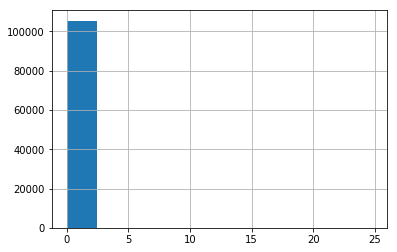

In [121]:
%matplotlib inline
data['Absence'].hist()

In [123]:
data = pd.get_dummies(data=data,columns=['marital_status','gender','full_tm_part_tm','reg_temp','age_band','tenure_band'],drop_first=True)

In [124]:
print(data.columns)

Index(['avg_salary', 'nbr_emp', 'Absence', 'marital_status_S', 'gender_Male',
       'full_tm_part_tm_Part-Time', 'reg_temp_T', 'age_band_25-34 Years',
       'age_band_35-44 Years', 'age_band_45-54 Years', 'age_band_55-64 Years',
       'age_band_Over 64 Years', 'age_band_Under 18 Years',
       'tenure_band_10-15 Years', 'tenure_band_2-3 Years',
       'tenure_band_3-5 Years', 'tenure_band_5-10 Years',
       'tenure_band_Over 15 Years', 'tenure_band_Under 1 Year'],
      dtype='object')


In [125]:
data.rename(columns={'full_tm_part_tm_Part-Time':'full_tm_part_tm_Part_Time','tenure_band_10-15 Years':'tenure_band_10_15','tenure_band_2-3 Years':'tenure_band_2_3','tenure_band_3-5 Years':'tenure_band_3_5','tenure_band_5-10 Years':'tenure_band_5_10','tenure_band_Over 15 Years':'tenure_band_Over_15','tenure_band_Under 1 Year':'tenure_band_Under_1','age_band_25-34 Years':'age_band_25_34','age_band_35-44 Years':'age_band_35_44','age_band_45-54 Years':'age_band_45_54','age_band_55-64 Years':'age_band_55_64','age_band_Over 64 Years':'age_band_Over_64','age_band_Under 18 Years':'age_band_Under_18'},inplace=True)

In [126]:
data.head()

,avg_salary,nbr_emp,Absence,marital_status_S,gender_Male,full_tm_part_tm_Part_Time,reg_temp_T,age_band_25_34,age_band_35_44,age_band_45_54,age_band_55_64,age_band_Over_64,age_band_Under_18,tenure_band_10_15,tenure_band_2_3,tenure_band_3_5,tenure_band_5_10,tenure_band_Over_15,tenure_band_Under_1
0,5342.77,3090,0.32,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2375.01,6806,0.09,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1088.80,826,0.01,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,15000.00,315,0.32,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,21339.86,764,0.47,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


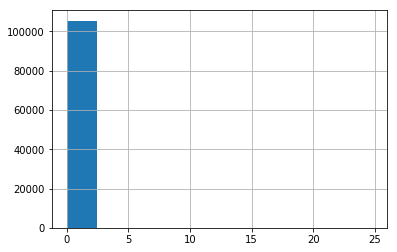

In [128]:
data['Absence'].hist()

In [54]:
ols_model = OLS.ols(data=data, formula="Absence~avg_salary+nbr_emp+marital_status_S+gender_Male+full_tm_part_tm_Part_Time+reg_temp_T+tenure_band_10_15+tenure_band_2_3+tenure_band_3_5+tenure_band_5_10+tenure_band_Over_15+tenure_band_Under_1+age_band_25_34+age_band_35_44+age_band_45_54+age_band_55_64+age_band_Over_64+age_band_Under_18").fit()

In [55]:
ols_model.summary()
## default suimary
## lertrs remove all the outliers

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Absence   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     640.4
Date:                Fri, 05 Oct 2018   Prob (F-statistic):               0.00
Time:                        10:48:57   Log-Likelihood:                -30843.
No. Observations:              105405   AIC:                         6.172e+04
Df Residuals:                  105386   BIC:                         6.191e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3239      0.005     65.474      0.000       0.314       0.334
avg_salary                 8.371e-06   1.49e-07     56.343      0.000    8.08e-06    8.66e-06
nbr_emp                   -9.263e-07   3.12e-08    -29.698      0.000   -9.87e-07   -8.65e-07
marital_status_S             -0.0149      0.002     -7.149      0.000      -0.019      -0.011
gender_Male                  -0.0050      0.002     -2.472      0.013      -0.009      -0.001
full_tm_part_tm_Part_Time    -0.1572      0.004    -39.906      0.000      -0.165      -0.149
reg_temp_T                   -0.1315      0.008    -16.515      0.000      -0.147      -0.116
tenure_band_10_15             0.0498      0.004     12.224      0.000       0.042       0.058
tenure_band_2_3               0.0049      0.004      1.316      0.188      -0.002       0.012
tenure_band_3_5               0.0239      0.004      6.639      0.000       0.017       0.031
tenure_band_5_10              0.0508      0.004     14.285      0.000       0.044       0.058
tenure_band_Over_15           0.0795      0.004     18.903      0.000       0.071       0.088
tenure_band_Under_1          -0.0518      0.003    -15.193      0.000      -0.058      -0.045
age_band_25_34                0.0401      0.004      9.128      0.000       0.031       0.049
age_band_35_44                0.0445      0.004     10.013      0.000       0.036       0.053
age_band_45_54                0.0335      0.005      7.430      0.000       0.025       0.042
age_band_55_64                0.0192      0.005      4.089      0.000       0.010       0.028
age_band_Over_64              0.0041      0.006      0.675      0.500      -0.008       0.016
age_band_Under_18            -0.0119      0.033     -0.359      0.719      -0.077       0.053
==============================================================================
Omnibus:                   116583.442   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        411010662.307
Skew:                           4.452   Prob(JB):                         0.00
Kurtosis:                     308.786   Cond. No.                     1.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## removing the outliers with resepct to absence ###

In [58]:
##Finding outliers
q1 = np.percentile((data['Absence']),15)
q3 =  np.percentile((data['Absence']),85)
IQR = q3-q1
floor = q1-1.5*IQR
ceiling = q3 + 1.5*IQR
print(q1,q3,IQR,floor,ceiling)

0.05 0.88 0.83 -1.1949999999999998 2.125


In [59]:
## listintg oulioers 
data[(data['Absence']<floor) | (data['Absence']>ceiling)].shape

(9, 19)

In [60]:
## removing poutliers
data.drop(data.index[(data['Absence']<floor) | (data['Absence']>ceiling)],inplace=True)
data.shape
## then gain go back and check for outliers

(105396, 19)

In [61]:
## lets again run the mdoel
ols_model = OLS.ols(data=data, formula="Absence~avg_salary+nbr_emp+marital_status_S+gender_Male+full_tm_part_tm_Part_Time+reg_temp_T+tenure_band_10_15+tenure_band_2_3+tenure_band_3_5+tenure_band_5_10+tenure_band_Over_15+tenure_band_Under_1+age_band_25_34+age_band_35_44+age_band_45_54+age_band_55_64+age_band_Over_64+age_band_Under_18").fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Absence   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     682.1
Date:                Fri, 05 Oct 2018   Prob (F-statistic):               0.00
Time:                        10:50:00   Log-Likelihood:                -27646.
No. Observations:              105396   AIC:                         5.533e+04
Df Residuals:                  105377   BIC:                         5.551e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3227      0.005     67.239      0.000       0.313       0.332
avg_salary                 8.393e-06   1.44e-07     58.228      0.000    8.11e-06    8.68e-06
nbr_emp                    -9.23e-07   3.03e-08    -30.502      0.000   -9.82e-07   -8.64e-07
marital_status_S             -0.0153      0.002     -7.608      0.000      -0.019      -0.011
gender_Male                  -0.0045      0.002     -2.269      0.023      -0.008      -0.001
full_tm_part_tm_Part_Time    -0.1566      0.004    -40.998      0.000      -0.164      -0.149
reg_temp_T                   -0.1325      0.008    -17.144      0.000      -0.148      -0.117
tenure_band_10_15             0.0517      0.004     13.077      0.000       0.044       0.059
tenure_band_2_3               0.0062      0.004      1.714      0.087      -0.001       0.013
tenure_band_3_5               0.0255      0.003      7.285      0.000       0.019       0.032
tenure_band_5_10              0.0523      0.003     15.163      0.000       0.046       0.059
tenure_band_Over_15           0.0815      0.004     19.978      0.000       0.073       0.089
tenure_band_Under_1          -0.0500      0.003    -15.136      0.000      -0.057      -0.044
age_band_25_34                0.0395      0.004      9.273      0.000       0.031       0.048
age_band_35_44                0.0439      0.004     10.169      0.000       0.035       0.052
age_band_45_54                0.0329      0.004      7.526      0.000       0.024       0.041
age_band_55_64                0.0173      0.005      3.801      0.000       0.008       0.026
age_band_Over_64              0.0030      0.006      0.520      0.603      -0.008       0.015
age_band_Under_18            -0.0121      0.032     -0.376      0.707      -0.075       0.051
==============================================================================
Omnibus:                     7118.522   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18228.351
Skew:                           0.398   Prob(JB):                         0.00
Kurtosis:                       4.875   Cond. No.                     1.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
##Finding outliers with salary
q1_sal = np.percentile((data['avg_salary']),15)
q3_sal =  np.percentile((data['avg_salary']),85)
IQR_sal = q3_sal-q1_sal
floor_sal = q1_sal-1.5*IQR_sal
ceiling_sal = q3_sal + 1.5*IQR_sal
print(q1_sal,q3_sal,IQR_sal,floor_sal,ceiling_sal)
## listintg oulioers
data[(data['avg_salary']<floor_sal) | (data['avg_salary']>ceiling_sal)].shape

## repeat untill we get 0


2219.3275000000003 8384.565 6165.2375 -7028.52875 17632.42125


(2329, 19)

In [63]:
data.drop(data.index[(data['avg_salary']<floor_sal) | (data['avg_salary']>ceiling_sal)],inplace=True)
data.shape

(103067, 19)

In [64]:
## lets again run the mdoel
ols_model = OLS.ols(data=data, formula="Absence~avg_salary+nbr_emp+marital_status_S+gender_Male+full_tm_part_tm_Part_Time+reg_temp_T+tenure_band_10_15+tenure_band_2_3+tenure_band_3_5+tenure_band_5_10+tenure_band_Over_15+tenure_band_Under_1+age_band_25_34+age_band_35_44+age_band_45_54+age_band_55_64+age_band_Over_64+age_band_Under_18").fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Absence   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     1056.
Date:                Fri, 05 Oct 2018   Prob (F-statistic):               0.00
Time:                        10:50:12   Log-Likelihood:                -23234.
No. Observations:              103067   AIC:                         4.651e+04
Df Residuals:                  103048   BIC:                         4.669e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2288      0.005     47.923      0.000       0.219       0.238
avg_salary                 3.326e-05   3.34e-07     99.479      0.000    3.26e-05    3.39e-05
nbr_emp                   -7.975e-07   2.92e-08    -27.291      0.000   -8.55e-07    -7.4e-07
marital_status_S             -0.0001      0.002     -0.063      0.950      -0.004       0.004
gender_Male                  -0.0205      0.002    -10.687      0.000      -0.024      -0.017
full_tm_part_tm_Part_Time    -0.0901      0.004    -23.929      0.000      -0.098      -0.083
reg_temp_T                   -0.1150      0.007    -15.426      0.000      -0.130      -0.100
tenure_band_10_15             0.0364      0.004      9.411      0.000       0.029       0.044
tenure_band_2_3               0.0061      0.004      1.724      0.085      -0.001       0.013
tenure_band_3_5               0.0202      0.003      5.947      0.000       0.014       0.027
tenure_band_5_10              0.0383      0.003     11.385      0.000       0.032       0.045
tenure_band_Over_15           0.0632      0.004     15.754      0.000       0.055       0.071
tenure_band_Under_1          -0.0397      0.003    -12.377      0.000      -0.046      -0.033
age_band_25_34                0.0159      0.004      3.870      0.000       0.008       0.024
age_band_35_44                0.0043      0.004      1.037      0.300      -0.004       0.013
age_band_45_54               -0.0076      0.004     -1.784      0.074      -0.016       0.001
age_band_55_64               -0.0151      0.004     -3.411      0.001      -0.024      -0.006
age_band_Over_64             -0.0065      0.006     -1.137      0.256      -0.018       0.005
age_band_Under_18            -0.0068      0.031     -0.218      0.827      -0.067       0.054
==============================================================================
Omnibus:                     9680.279   Durbin-Watson:                   0.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5506.680
Skew:                           0.426   Prob(JB):                         0.00
Kurtosis:                       2.253   Cond. No.                     1.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
##Finding outliers with number of employee
q1_nbr = np.percentile((data['nbr_emp']),15)
q3_nbr =  np.percentile((data['nbr_emp']),85)
IQR_nbr = q3_nbr-q1_nbr
floor_nbr = q1_nbr-1.5*IQR_nbr
ceiling_nbr = q3_nbr + 1.5*IQR_nbr
print(q1_nbr,q3_nbr,IQR_nbr,floor_nbr,ceiling_nbr)
## listintg oulioers
data[(data['nbr_emp']<floor_nbr) | (data['nbr_emp']>ceiling_nbr)].shape

263.0 5021.0 4758.0 -6874.0 12158.0


(0, 19)

In [98]:
data.drop(data.index[(data['nbr_emp']<floor_nbr) | (data['nbr_emp']>ceiling_nbr)],inplace=True)
data.shape

(89793, 19)

## after removing poutliers respec to all the nbr and sala col

In [99]:
## lets again run the mdoel
ols_model = OLS.ols(data=data, formula="Absence~avg_salary+nbr_emp+marital_status_S+gender_Male+full_tm_part_tm_Part_Time+reg_temp_T+tenure_band_10_15+tenure_band_2_3+tenure_band_3_5+tenure_band_5_10+tenure_band_Over_15+tenure_band_Under_1+age_band_25_34+age_band_35_44+age_band_45_54+age_band_55_64+age_band_Over_64+age_band_Under_18").fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Absence   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1146.
Date:                Fri, 05 Oct 2018   Prob (F-statistic):               0.00
Time:                        10:51:33   Log-Likelihood:                -20537.
No. Observations:               89793   AIC:                         4.111e+04
Df Residuals:                   89774   BIC:                         4.129e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3060      0.005     57.959      0.000       0.296       0.316
avg_salary                 3.139e-05   3.51e-07     89.499      0.000    3.07e-05    3.21e-05
nbr_emp                   -2.502e-05   3.86e-07    -64.771      0.000   -2.58e-05   -2.43e-05
marital_status_S              0.0020      0.002      0.971      0.332      -0.002       0.006
gender_Male                  -0.0218      0.002    -10.565      0.000      -0.026      -0.018
full_tm_part_tm_Part_Time    -0.0912      0.004    -22.056      0.000      -0.099      -0.083
reg_temp_T                   -0.1156      0.008    -14.371      0.000      -0.131      -0.100
tenure_band_10_15             0.0287      0.004      6.955      0.000       0.021       0.037
tenure_band_2_3               0.0032      0.004      0.833      0.405      -0.004       0.011
tenure_band_3_5               0.0239      0.004      6.508      0.000       0.017       0.031
tenure_band_5_10              0.0390      0.004     10.768      0.000       0.032       0.046
tenure_band_Over_15           0.0562      0.004     13.124      0.000       0.048       0.065
tenure_band_Under_1          -0.0398      0.003    -11.419      0.000      -0.047      -0.033
age_band_25_34                0.0227      0.004      5.048      0.000       0.014       0.031
age_band_35_44                0.0137      0.005      3.018      0.003       0.005       0.023
age_band_45_54                0.0042      0.005      0.898      0.369      -0.005       0.013
age_band_55_64             5.307e-05      0.005      0.011      0.991      -0.009       0.009
age_band_Over_64              0.0023      0.006      0.376      0.707      -0.010       0.014
age_band_Under_18            -0.0186      0.034     -0.553      0.580      -0.085       0.047
==============================================================================
Omnibus:                    12907.674   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4101.422
Skew:                           0.275   Prob(JB):                         0.00
Kurtosis:                       2.109   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
# data.drop_duplicates(inplace=True)
# data.shape
data.duplicated().sum()

0

In [101]:
## lets again run the mdoel
ols_model = OLS.ols(data=data, formula="Absence~avg_salary+nbr_emp+marital_status_S+gender_Male+full_tm_part_tm_Part_Time+reg_temp_T+tenure_band_10_15+tenure_band_2_3+tenure_band_3_5+tenure_band_5_10+tenure_band_Over_15+tenure_band_Under_1+age_band_25_34+age_band_35_44+age_band_45_54+age_band_55_64+age_band_Over_64+age_band_Under_18").fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Absence   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1146.
Date:                Fri, 05 Oct 2018   Prob (F-statistic):               0.00
Time:                        10:51:43   Log-Likelihood:                -20537.
No. Observations:               89793   AIC:                         4.111e+04
Df Residuals:                   89774   BIC:                         4.129e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3060      0.005     57.959      0.000       0.296       0.316
avg_salary                 3.139e-05   3.51e-07     89.499      0.000    3.07e-05    3.21e-05
nbr_emp                   -2.502e-05   3.86e-07    -64.771      0.000   -2.58e-05   -2.43e-05
marital_status_S              0.0020      0.002      0.971      0.332      -0.002       0.006
gender_Male                  -0.0218      0.002    -10.565      0.000      -0.026      -0.018
full_tm_part_tm_Part_Time    -0.0912      0.004    -22.056      0.000      -0.099      -0.083
reg_temp_T                   -0.1156      0.008    -14.371      0.000      -0.131      -0.100
tenure_band_10_15             0.0287      0.004      6.955      0.000       0.021       0.037
tenure_band_2_3               0.0032      0.004      0.833      0.405      -0.004       0.011
tenure_band_3_5               0.0239      0.004      6.508      0.000       0.017       0.031
tenure_band_5_10              0.0390      0.004     10.768      0.000       0.032       0.046
tenure_band_Over_15           0.0562      0.004     13.124      0.000       0.048       0.065
tenure_band_Under_1          -0.0398      0.003    -11.419      0.000      -0.047      -0.033
age_band_25_34                0.0227      0.004      5.048      0.000       0.014       0.031
age_band_35_44                0.0137      0.005      3.018      0.003       0.005       0.023
age_band_45_54                0.0042      0.005      0.898      0.369      -0.005       0.013
age_band_55_64             5.307e-05      0.005      0.011      0.991      -0.009       0.009
age_band_Over_64              0.0023      0.006      0.376      0.707      -0.010       0.014
age_band_Under_18            -0.0186      0.034     -0.553      0.580      -0.085       0.047
==============================================================================
Omnibus:                    12907.674   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4101.422
Skew:                           0.275   Prob(JB):                         0.00
Kurtosis:                       2.109   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
data.columns
feature_columsn = ['avg_salary','nbr_emp','marital_status_S','gender_Male','full_tm_part_tm_Part_Time','reg_temp_T','age_band_25_34','age_band_35_44','age_band_45_54','']

In [103]:
y = data['Absence']
X = data[data.columns.difference(['Absence'])]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=2)

In [104]:
regressor = RandomForestRegressor(n_estimators=800,random_state=0,min_samples_leaf=15,n_jobs=-1)
##regressor = RandomForestRegressor(andom_state=0)

In [105]:
regressor.fit(X_train,y_train)
# regressor = RandomForestRegressor(n_estimators=100,random_state=0)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [106]:
## with regressor = RandomForestRegressor(n_estimators=100,random_state=0)
regressor.score(X_test,y_test)

0.34976740215129976

In [117]:
y_pred = regressor.predict(X_test)

In [59]:
%timeit
### grd search for best param
param_grid = {"n_estimators": list(range(100,3000,100)),
              "min_samples_leaf":list(range(10,50,10)),
               "n_jobs":[-1]
    }

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)


0.33875501463491176
{'min_samples_leaf': 10, 'n_estimators': 900, 'n_jobs': -1}


In [2]:
listss = list(range(40,500,50))
print(listss)

[40, 90, 140, 190, 240, 290, 340, 390, 440, 490]
